# Window Process 

In [131]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt 
import numpy as np

import datetime

from tensorflow import keras
from tensorflow.keras import layers


# Lendo Dfs

In [132]:
# 60%
PATH_TREINO = '../Data/3_Gold/Treino_all_stocks.csv'
DF_TREINO = pd.read_csv(PATH_TREINO, sep=",")
train_dataset = DF_TREINO
train_dataset = train_dataset.drop(['oil_5','usd_5','abev_5','jbs_5','petr_5','vale_5',], axis=1)
train_labels = train_dataset.pop('ibova_5')
# train_dataset = train_dataset.iloc[:476]

# 20%
PATH_VALIDACAO = '../Data/3_Gold/Validacao_all_stocks.csv'
DF_VALIDACAO = pd.read_csv(PATH_VALIDACAO, sep=",")
valid_dataset = DF_VALIDACAO
valid_dataset = valid_dataset.drop(['ibova_5','oil_5','usd_5','abev_5','jbs_5','petr_5','vale_5',],axis=1)
# valid_labels = valid_dataset.pop('ibova_5') 

# 20%
PATH_TESTE = '../Data/3_Gold/Teste_all_stocks.csv'
DF_TESTE = pd.read_csv(PATH_TESTE, sep=",")
test_dataset = DF_TESTE
test_dataset = test_dataset.drop(['oil_5','usd_5','abev_5','jbs_5','petr_5','vale_5',],axis=1)
test_labels = test_dataset.pop('ibova_5')


# Window generator

In [133]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_dataset, val_df=valid_dataset, test_df=test_dataset,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
      
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

def plot(self, model=None, plot_col='ibova_0', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  # print(f"inputs: {len(inputs)}")
  # print(f"plot_col_index: {plot_col_index}")
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('ibova_0')

WindowGenerator.plot = plot

## Window Generating

In [134]:
# count dos dataframes
# train_dataset[train_dataset.columns[0]].count()
# test_dataset[test_dataset.columns[0]].count()
# valid_dataset[valid_dataset.columns[0]].count()
# df[df.columns[0]].count()

train_count = len(train_dataset)
test_count = len(test_dataset)

w1 = WindowGenerator(input_width=50, label_width=50, shift=2, label_columns=['ibova_0'])
w1


Total window size: 52
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51]
Label column name(s): ['ibova_0']

In [135]:
# # Stack three slices, the length of the total window.
# example_window = tf.stack([np.array(train_dataset[:w1.total_window_size]),
#                            np.array(train_dataset[100:100+w1.total_window_size]),
#                            np.array(train_dataset[200:200+w1.total_window_size])])

# example_inputs, example_labels = w1.split_window(example_window)

# print('All shapes are: (batch, time, features)')
# print(f'Window shape: {example_window.shape}')
# print(f'Inputs shape: {example_inputs.shape}')
# print(f'Labels shape: {example_labels.shape}')


In [136]:
w1.train.element_spec

(TensorSpec(shape=(None, 50, 36), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 50, 1), dtype=tf.float32, name=None))

#### Definindo modelo de base

In [137]:
# class Baseline(tf.keras.Model):
#   def __init__(self, label_index=None):
#     super().__init__()
#     self.label_index = label_index

#   def call(self, inputs):
#     if self.label_index is None:
#       return inputs
#     result = inputs[:, :, self.label_index]
#     return result[:, :, tf.newaxis]
    
# column_indices = {name: i for i, name in enumerate(train_dataset.columns)}

# baseline = Baseline(label_index=column_indices['ibova_0'])

# baseline.compile(loss=tf.losses.MeanSquaredError(),
#                  metrics=[tf.metrics.MeanAbsoluteError()])

# val_performance = {}
# performance = {}
# val_performance['Baseline'] = baseline.evaluate(w1.val)
# performance['Baseline'] = baseline.evaluate(w1.test, verbose=0)


Input shape: (32, 50, 36)
Output shape: (32, 50, 1)


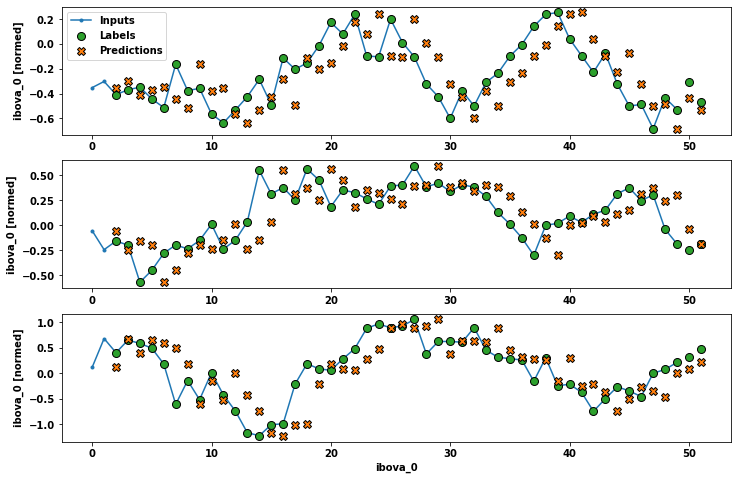

In [138]:
print('Input shape:', w1.example[0].shape)
print('Output shape:', baseline(w1.example[0]).shape)
w1.plot(baseline)


# Plataforma do modelo

In [139]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse',patience=patience, mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

## Modelos:

In [140]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [141]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])


##### Multi-step 

In [142]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 36)
Output shape: (32, 1, 1)


In [143]:
# Os modelos definidos dessa forma só funcionam com as entradas exatamente assim...
# 3 de entrada prevendo 1 do futuro

print('Input shape:', w1.example[0].shape)
try:
  print('Output shape:', multi_step_dense(w1.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 50, 36)

ValueError:Exception encountered when calling layer "sequential_22" (type Sequential).

Input 0 of layer "dense_45" is incompatible with the layer: expected axis -1 of input shape to have value 108, but received input with shape (32, 1800)

Call arguments received by layer "sequential_22" (type Sequential):
  • inputs=tf.Tensor(shape=(32, 50, 36), dtype=float32)
  • training=None
  • mask=None


##### Modelo convolucional CNN

In [144]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['ibova_0'])

# conv_window

In [145]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['ibova_0'])

wide_conv_window

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

### Executando o modelo CNN

Conv model on `conv_window`
Input shape: (32, 3, 36)
Labels shape: (32, 1, 1)
Output shape: (32, 1, 1)


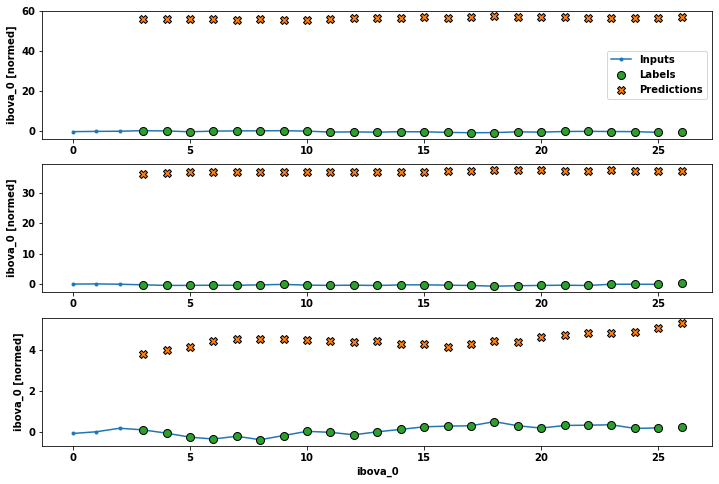

In [146]:
print("Conv model on `conv_window`")

print('Input shape:', conv_window.example[0].shape)
print('Labels shape:', conv_window.example[1].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

wide_conv_window.plot(conv_model)


# RNN (LSTM)

In [147]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', w1.example[0].shape)
print('Output shape:', lstm_model(w1.example[0]).shape)


Input shape: (32, 50, 36)
Output shape: (32, 50, 1)


# Executando modelos

Epoch 1/20
44/44 [==============================] - 2s 17ms/step - loss: 13989.4629 - mean_absolute_error: 102.9893 - val_loss: 1029.9757 - val_mean_absolute_error: 28.3358
Epoch 2/20
44/44 [==============================] - 0s 5ms/step - loss: 7336.8589 - mean_absolute_error: 74.5216 - val_loss: 507.4890 - val_mean_absolute_error: 19.8366
Epoch 3/20
44/44 [==============================] - 0s 5ms/step - loss: 3463.5374 - mean_absolute_error: 51.1350 - val_loss: 221.7701 - val_mean_absolute_error: 13.0446
Epoch 4/20
44/44 [==============================] - 0s 5ms/step - loss: 1445.7515 - mean_absolute_error: 32.9708 - val_loss: 85.0579 - val_mean_absolute_error: 7.9831
Epoch 5/20
44/44 [==============================] - 0s 6ms/step - loss: 529.0804 - mean_absolute_error: 19.8725 - val_loss: 28.8299 - val_mean_absolute_error: 4.5569
Epoch 6/20
44/44 [==============================] - 0s 5ms/step - loss: 172.7979 - mean_absolute_error: 11.2608 - val_loss: 9.4690 - val_mean_absolute_error

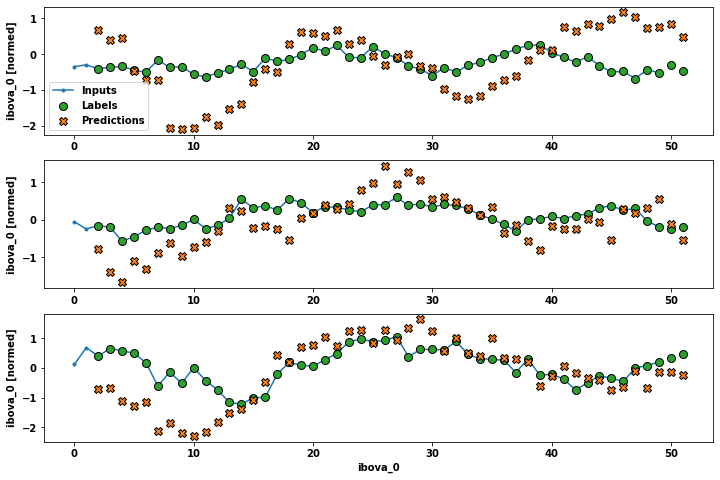

In [148]:
WINDOW = w1
MODEL = linear

history = compile_and_fit(MODEL, WINDOW)

val_performance['Linear'] = MODEL.evaluate(WINDOW.val)
performance['Linear'] = MODEL.evaluate(WINDOW.test, verbose=0)

w1.plot(linear)

Epoch 1/20
44/44 [==============================] - 2s 15ms/step - loss: 12.8182 - mean_absolute_error: 2.2209 - val_loss: 0.1076 - val_mean_absolute_error: 0.2628
Epoch 2/20
44/44 [==============================] - 0s 8ms/step - loss: 0.1163 - mean_absolute_error: 0.2453 - val_loss: 0.0378 - val_mean_absolute_error: 0.1492
Epoch 3/20
44/44 [==============================] - 0s 8ms/step - loss: 0.0354 - mean_absolute_error: 0.1464 - val_loss: 0.0209 - val_mean_absolute_error: 0.1112
Epoch 4/20
44/44 [==============================] - 0s 9ms/step - loss: 0.0212 - mean_absolute_error: 0.1119 - val_loss: 0.0145 - val_mean_absolute_error: 0.0927
Epoch 5/20
44/44 [==============================] - 0s 8ms/step - loss: 0.0151 - mean_absolute_error: 0.0941 - val_loss: 0.0120 - val_mean_absolute_error: 0.0840
Epoch 6/20
44/44 [==============================] - 0s 8ms/step - loss: 0.0125 - mean_absolute_error: 0.0857 - val_loss: 0.0103 - val_mean_absolute_error: 0.0774
Epoch 7/20
44/44 [========

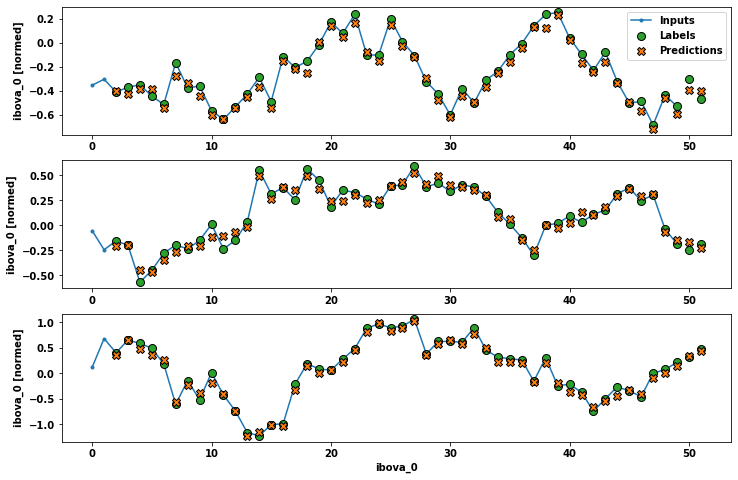

In [149]:
WINDOW = w1
MODEL = dense

history = compile_and_fit(MODEL, WINDOW)

val_performance['Dense'] = MODEL.evaluate(WINDOW.val)
performance['Dense'] = MODEL.evaluate(WINDOW.test, verbose=0)

w1.plot(dense)

CNN

14/14 [==============================] - 0s 4ms/step - loss: 0.0050 - mean_absolute_error: 0.0540


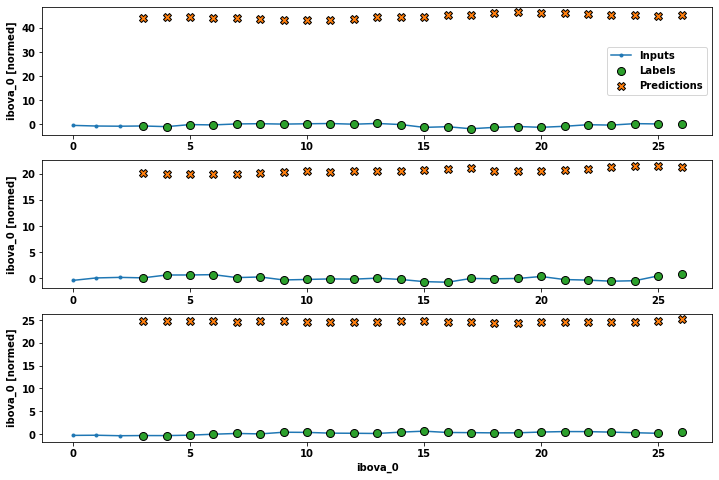

In [150]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['ibova_0'])

wide_conv_window

val_performance['CNN'] = MODEL.evaluate(WINDOW.val)
performance['CNN'] = MODEL.evaluate(WINDOW.test, verbose=0)

wide_conv_window.plot(conv_model)


Epoch 1/20
44/44 [==============================] - 6s 45ms/step - loss: 0.1934 - mean_absolute_error: 0.3429 - val_loss: 0.0813 - val_mean_absolute_error: 0.2180
Epoch 2/20
44/44 [==============================] - 1s 30ms/step - loss: 0.0920 - mean_absolute_error: 0.2290 - val_loss: 0.0593 - val_mean_absolute_error: 0.1916
Epoch 3/20
44/44 [==============================] - 1s 30ms/step - loss: 0.0660 - mean_absolute_error: 0.1929 - val_loss: 0.0433 - val_mean_absolute_error: 0.1630
Epoch 4/20
44/44 [==============================] - 1s 28ms/step - loss: 0.0550 - mean_absolute_error: 0.1747 - val_loss: 0.0325 - val_mean_absolute_error: 0.1403
Epoch 5/20
44/44 [==============================] - 1s 31ms/step - loss: 0.0453 - mean_absolute_error: 0.1563 - val_loss: 0.0254 - val_mean_absolute_error: 0.1226
Epoch 6/20
44/44 [==============================] - 2s 34ms/step - loss: 0.0357 - mean_absolute_error: 0.1360 - val_loss: 0.0200 - val_mean_absolute_error: 0.1071
Epoch 7/20
44/44 [====

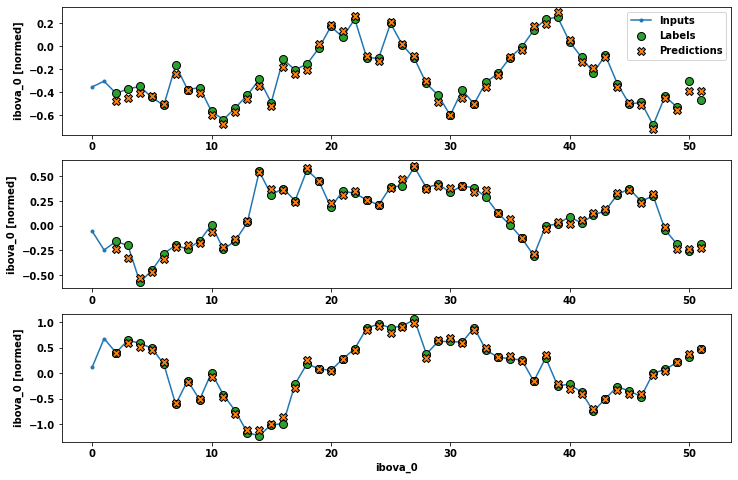

In [151]:
WINDOW = w1
MODEL = lstm_model

history = compile_and_fit(MODEL, WINDOW)

val_performance['LSTM'] = MODEL.evaluate(WINDOW.val)
performance['LSTM'] = MODEL.evaluate(WINDOW.test, verbose=0)

w1.plot(lstm_model)

### Plotando resultados do modelo

# Avaliando diferentes modelos

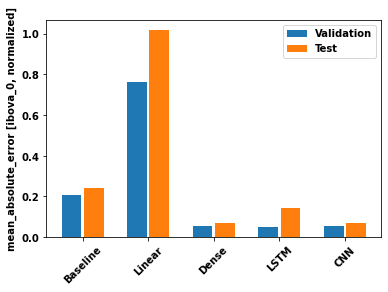

In [152]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [ibova_0, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [153]:
history

In [154]:
print("Erro Absoluto Medio")
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


Erro Absoluto Medio
Baseline    : 0.2423
Linear      : 1.0180
Dense       : 0.0690
LSTM        : 0.1435
CNN         : 0.0690


# Instanciando Tuner

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/keras_tuner.ipynb#scrollTo=McO82AXOuxXh

In [155]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mse',
                     max_epochs=10,
                     factor=3,
                     directory='logs',
                     project_name='hyper_parameters')

NameError: name 'model_builder' is not defined

In [ ]:
# early_stop = keras.callbacks.EarlyStopping(
#   monitor='val_mse', patience=50, mode='min' ,restore_best_weights=True)
	
EPOCHS = 500

tuner.search(train_dataset, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=1)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=20)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Selecionando a melhor epoca do modelo

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs


model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=1)

# Select the best epoch
val_mse_per_epoch = history.history['val_mse']
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))


# Treinando modelo

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(train_dataset, train_labels, epochs=best_epoch, validation_split=0.2, verbose=1)


In [ ]:
eval_result = hypermodel.evaluate(test_dataset, test_labels)
print("[test loss, test accuracy]:", eval_result)

# Avaliando o modelo

In [ ]:
# print(f'train_dataset: {train_dataset.columns()} \n')
# print(f'valid_dataset: {valid_dataset.columns()} \n')
# print(f'test_dataset: {test_dataset.columns()} \n')

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
print(f'Min MSE: {hist.mse.min()}')
print(f'Min Val_MSE: {hist.val_mse.min()}')

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ibova_0]')
  plt.plot(hist['epoch'], hist['mae'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ibova_0^2$]')
  plt.plot(hist['epoch'], hist['mse'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print(f"Testing set Mean Abs Error: {mse:5.2f} ibova_0")

# Realizando as previsões

In [ ]:
test_predictions = model.predict(test_dataset).flatten()

# Avaliando as previsões:

In [ ]:
def show_test_labels():
	# Imprimindo valores reais
	plt.plot(test_labels, color ='r', label='ibova_REAL')
	plt.xlabel("Dates")
	plt.ylabel("Variation ROC")
	plt.title("ibova_REAL")
	plt.legend()

def show_model_predictions():
	# Imprimindo previsoes
	plt.plot(test_predictions, color ='g', label='predictions_MODEL')
	plt.xlabel("Dates")
	plt.ylabel("Variation ROC")
	plt.title("predictions_MODEL")
	plt.legend()

def show_compare_graph():
	# Predictt X Real values
	plt.plot(test_labels, color ='r', label='ibova_REAL')
	plt.plot(test_predictions, color ='g', label='predictions_MODEL')
	plt.xlabel("Dates")
	plt.ylabel("Variation ROC")
	plt.title("Predict X Real values")
	plt.legend()
	plt.show()

def show_true_predict_values():
	plt.figure(figsize=(24,4))
	plt.scatter(test_labels, test_predictions)
	plt.xlabel('True Values [ibova_0]')
	plt.ylabel('Predictions [ibova_0]')
	plt.axis('equal')
	plt.axis('square')
	plt.xlim([0,plt.xlim()[1]])
	plt.ylim([0,plt.ylim()[1]])
	_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
show_compare_graph()

In [ ]:
show_model_predictions()

In [ ]:
# Analisando Medias:

print(f'Massa de predição: {test_predictions.mean()}')
print(f'Massa inicial: {ibova_test.mean()}')
print(f'Diferenças das médias: {ibova_test.mean() - test_predictions.mean()}')

# Add o RM_MSE medio

In [ ]:
# test_dataset